In [33]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [34]:
apple_data=pd.read_csv(r"C:\Users\agnes\Documents\apziva_ai_residency\project5\data\appl_data.csv")
apple_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059425,135480400
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349129,146322800
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925644,118387200
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582664,108872000
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750252,132079200


In [35]:
apple_data= apple_data.set_index(['Date'])
#train_data = stock_data.set_index(['Date'])
#train_data.head()

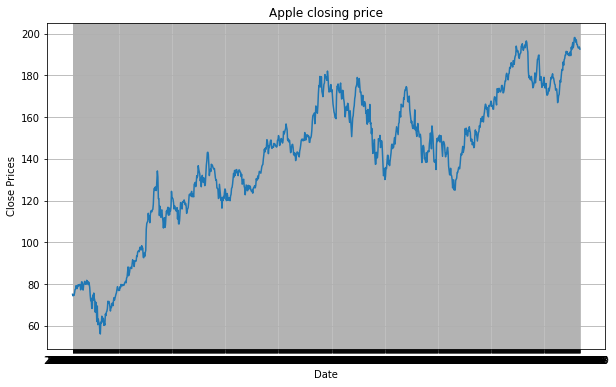

In [36]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(train_data['Close'])
plt.title('Apple closing price')
plt.show()

<AxesSubplot: ylabel='Density'>

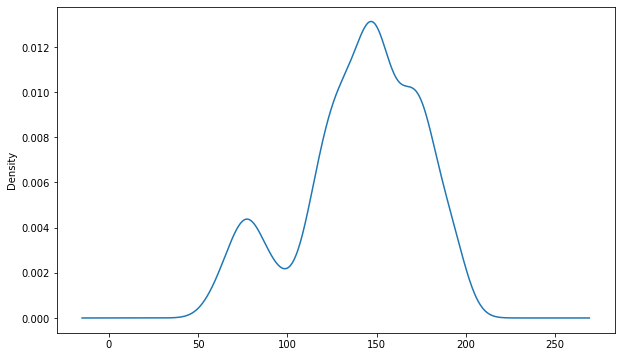

In [37]:

#Distribution of the dataset
df_close = train_data['Close']
df_close.plot(kind='kde')

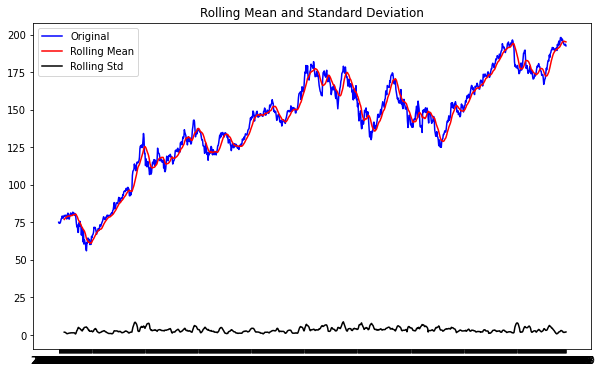

Results of dickey fuller test
Test Statistics                  -1.555344
p-value                           0.505978
No. of lags used                  0.000000
Number of observations used    1005.000000
critical value (1%)              -3.436873
critical value (5%)              -2.864420
critical value (10%)             -2.568304
dtype: float64


In [38]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # details dft
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

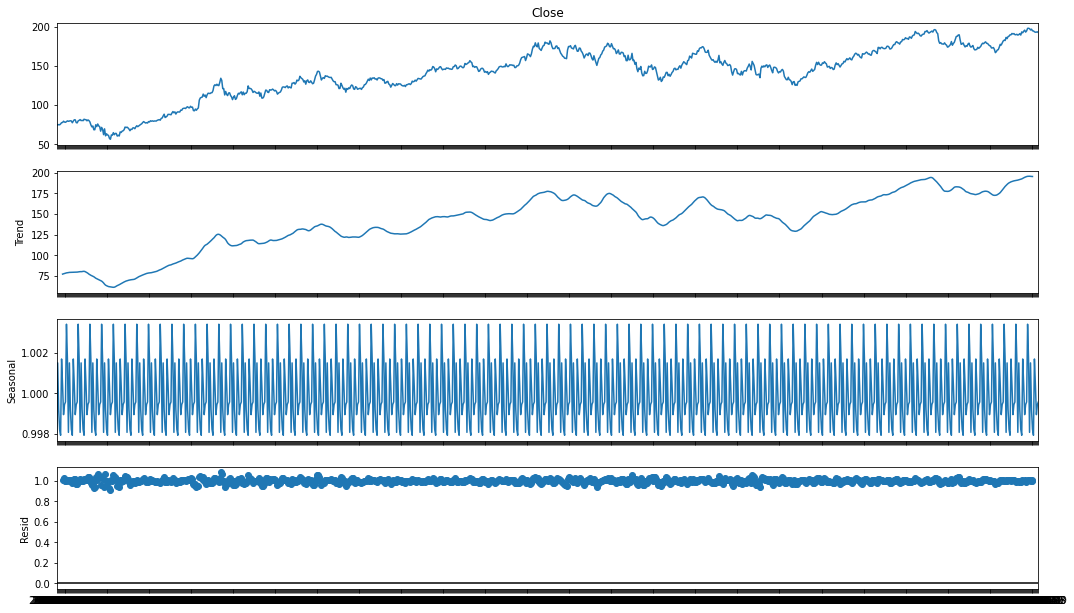

In [40]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period=12)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


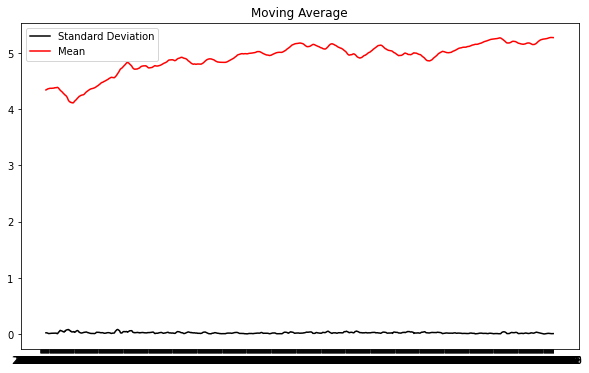

In [41]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

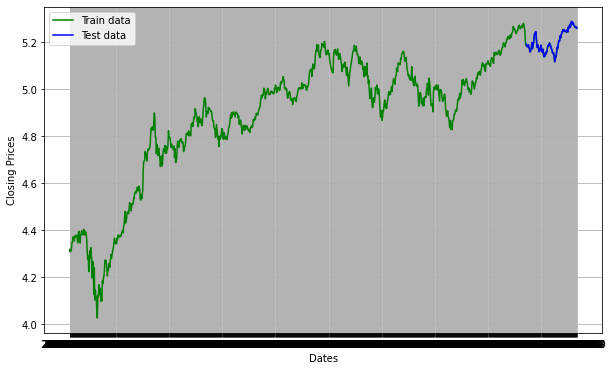

In [42]:

#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [43]:
valid_data_log = pd.concat([train_data.tail(25), test_data.head()]).to_frame(name='Close')
valid_data = np.exp(valid_data_log)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4319.048, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4334.385, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4333.855, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4319.291, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4332.447, Time=2.60 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4332.458, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4330.426, Time=2.65 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4334.070, Time=0.13 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 7.050 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  902
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2170.192
Date:                Wed, 01 May 2024   AIC                          -4334.385
Time:                       

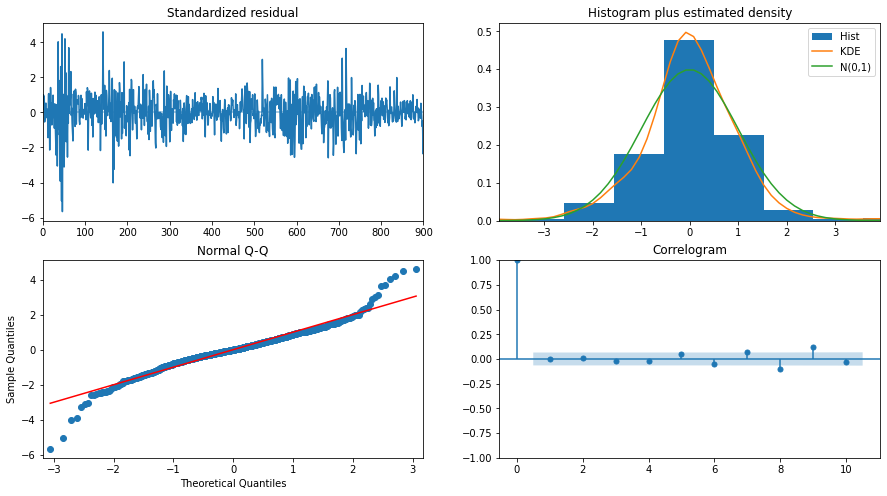

In [44]:

model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [46]:
model = ARIMA(train_data, order=(2,1,0))
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  902
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2169.089
Date:                Wed, 01 May 2024   AIC                          -4332.178
Time:                        21:17:11   BIC                          -4317.767
Sample:                             0   HQIC                         -4326.673
                                - 902                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1352      0.023     -5.925      0.000      -0.180      -0.091
ar.L2          0.0110      0.021      0.515      0.606      -0.031       0.053
sigma2         0.0005    1.4e-05     33.857      0.0

In [47]:

prediction = fitted.predict(199, 228)
len(prediction)

30

In [48]:
dates = valid_data.index
df_pred_convert = pd.DataFrame(np.exp(prediction).values, index = pd.to_datetime(dates), columns=['Close'])
train_slice = train_data[199:224]
test_slice = test_data[: 5]

In [64]:
type(df_pred_convert.squeeze())
converted=df_pred_convert.squeeze()
converted
import datetime as dt 
from dateutil import tz 
  
  
tz_string = dt.datetime.now(dt.timezone.utc).astimezone().tzname() 

Date
2023-07-03    116.368429
2023-07-05    117.268417
2023-07-06    116.973271
2023-07-07    115.893851
2023-07-10    115.123527
2023-07-11    115.040837
2023-07-12    116.389277
2023-07-13    111.931930
2023-07-14    114.693966
2023-07-17    109.756083
2023-07-18    108.712965
2023-07-19    110.211657
2023-07-20    114.348697
2023-07-21    118.522222
2023-07-24    118.781648
2023-07-25    116.634043
2023-07-26    115.991445
2023-07-27    119.003825
2023-07-28    119.287192
2023-07-31    119.250150
2023-08-01    120.159383
2023-08-02    119.524118
2023-08-03    118.203105
2023-08-04    118.542328
2023-08-07    117.521657
2023-08-08    114.301938
2023-08-09    114.952274
2023-08-10    115.928070
2023-08-11    116.523674
2023-08-14    118.720614
Name: Close, dtype: float64

TypeError: tz must be string or tzinfo subclass.

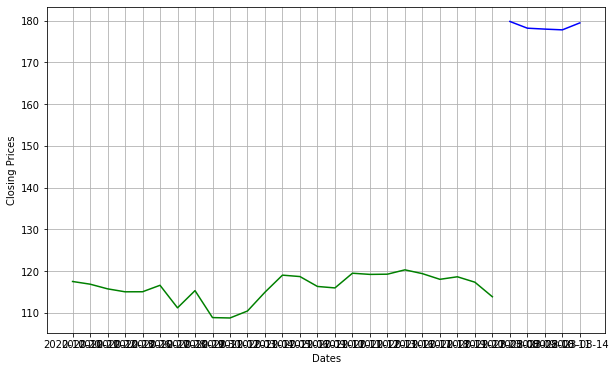

In [66]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(np.exp(train_slice), 'green', label='Train data')
plt.plot(np.exp(test_slice), 'blue', label='Test data')
plt.plot(converted, 'orange', label='Predicted Data')
plt.legend()

In [67]:
def bollinger_bands(df, n, m):
    TP = df['Close']
    data = TP
    B_MA = pd.Series((data.rolling(n, min_periods=n).mean()), name='B_MA')
    sigma = data.rolling(n, min_periods=n).std()
    BU = pd.Series((B_MA + m * sigma), name='BU')
    BL = pd.Series((B_MA - m * sigma), name='BL')
    df = df.join(B_MA)
    df = df.join(BU)
    df = df.join(BL)
    
    return df

In [68]:

df_pred_convert

,Close
Date,
2023-07-03,116.368429
2023-07-05,117.268417
2023-07-06,116.973271
2023-07-07,115.893851
2023-07-10,115.123527
2023-07-11,115.040837
2023-07-12,116.389277
2023-07-13,111.931930
2023-07-14,114.693966


In [69]:
dfb = bollinger_bands(df_pred_convert, 20, 2)

In [70]:
def add_signal(df):
    buy_list = []
    sell_list = []
    for i in range(len(df['Close'])):
        if df['Close'][i] > df['BU'][i]:           # sell signal     daily
#         if df['High'][i] > df['BU'][i]:             # sell signal     weekly
            buy_list.append(np.nan)
            sell_list.append(df['Close'][i])
        elif df['Close'][i] < df['BL'][i]:         # buy signal      daily
#         elif df['Low'][i] < df['BL'][i]:            # buy signal      weekly
            buy_list.append(df['Close'][i])
            sell_list.append(np.nan)  
        else:
            buy_list.append(np.nan)
            sell_list.append(np.nan)
         
    buy_list = pd.Series(buy_list, name='Buy')
    sell_list = pd.Series(sell_list, name='Sell')
        
    df = df.join(buy_list)
    df = df.join(sell_list)        
     
    return df

In [71]:
def plot_signals(df, ticker):
    # plot price
    plt.figure(figsize=(15,5))
    plt.plot(df.index, df['Close'])
    plt.title('Price chart (Close) ' + str(ticker))
    plt.show()

    # plot  values and significant levels
    plt.figure(figsize=(15,5))
    plt.title('Bollinger Bands chart ' + str(ticker))
    plt.plot(df.index, df['Close'], label='Close')
    
    plt.plot(df.index, df['BU'], label='B_Upper', alpha=0.3)
    plt.plot(df.index, df['BL'], label='B_Lower', alpha=0.3)
    plt.plot(df.index, df['B_MA'], label='B_SMA', alpha=0.3)
    plt.fill_between(df.index, df['BU'], df['BL'], color='grey', alpha=0.1)

    plt.scatter(df.index, df['Buy'], label='Buy', marker='^')
    plt.scatter(df.index, df['Sell'], label='Sell', marker='v')

    plt.legend()

    plt.show()

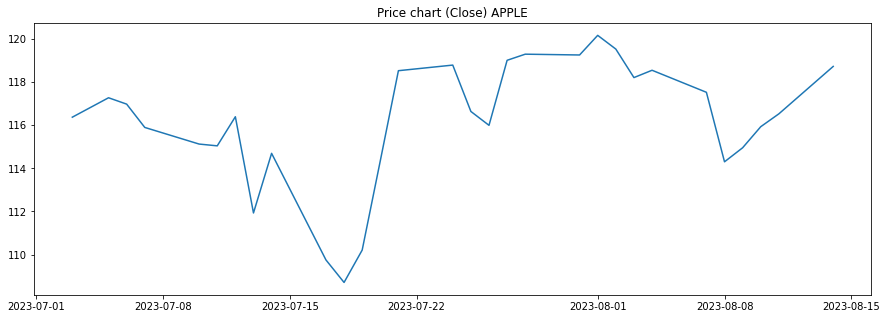

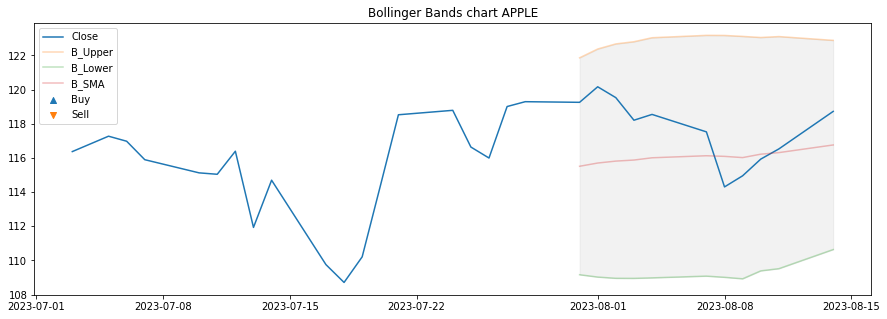

In [72]:
dfb = add_signal(dfb)
plot_signals(dfb, 'APPLE')